In [1]:
import os
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import local_features as lf
import scipy.ndimage


In [6]:
def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image."""
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)


path = '3labels/'

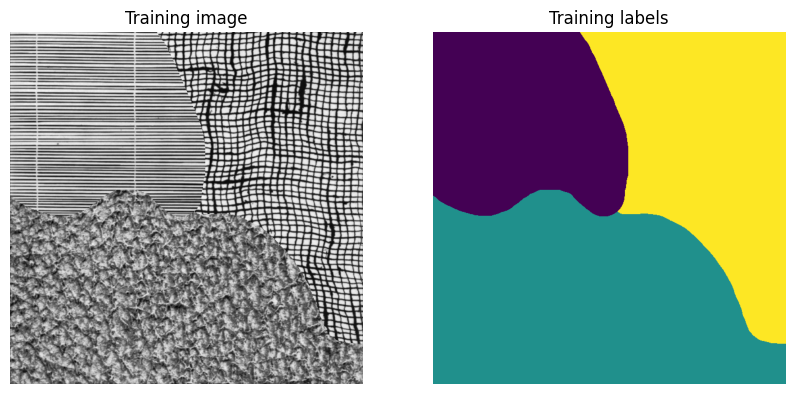

In [ ]:
training_image = skimage.io.imread(os.path.join(path, 'training_image.png'))
training_image = training_image.astype(float)
training_labels = skimage.io.imread(os.path.join(path, 'training_labels.png'))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(training_image, cmap='gray')
plt.title('Training image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(training_labels)
plt.title('Training labels')
plt.axis('off')
plt.show()


In [11]:
training_labels = ind2labels(training_labels)
nr_labels = np.max(training_labels)+1  # number of labels in training image



print("Number of labels in training image: ", nr_labels)

print("Training labels shape: ", training_labels.shape)

Number of labels in training image:  3
Training labels shape:  (640, 640)


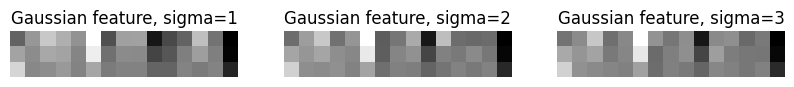

In [ ]:
# Compute multi-scale Gaussian features
sigma = [1,2,3]  # Three different scales to capture patterns of different sizes
features = lf.get_gauss_feat_multi(training_image, sigma)




In [14]:
# Reshape features for easier processing
features = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
labels = training_labels.ravel()

In [15]:
# Choose a random subset for efficiency
nr_keep = 15000  # number of features randomly picked for clustering 
keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep]

features_subset = features[keep_indices,:]
labels_subset = labels[keep_indices]

In [16]:
# Cluster the features
nr_clusters = 1000  # number of feature clusters
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, batch_size=2*nr_clusters)
kmeans.fit(features_subset)
assignment = kmeans.labels_

In [17]:
# Calculate probability of each label for each cluster
edges = np.arange(nr_clusters+1)-0.5  # histogram edges halfway between integers
hist = np.zeros((nr_clusters,nr_labels))
for l in range(nr_labels):
    hist[:,l] = np.histogram(assignment[labels_subset==l],bins=edges)[0]
sum_hist = np.sum(hist,axis=1)
cluster_probabilities = hist/(sum_hist.reshape(-1,1))

In [19]:
# Load test image and compute features
testing_image = skimage.io.imread(os.path.join(path, 'testing_image.png'))
testing_image = testing_image.astype(float)

features_testing = lf.get_gauss_feat_multi(testing_image, sigma)
features_testing = features_testing.reshape((features_testing.shape[0], features_testing.shape[1]*features_testing.shape[2]))

# Assign each feature to nearest cluster
assignment_testing = kmeans.predict(features_testing)

In [20]:
# Create probability image
probability_image = np.zeros((assignment_testing.size, nr_labels))
for l in range(nr_labels):
    probability_image[:,l] = cluster_probabilities[assignment_testing, l]
probability_image = probability_image.reshape(testing_image.shape + (nr_labels,))

In [22]:

P_rgb = np.zeros(probability_image.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb[:,:,:k] = probability_image[:,:,:k]

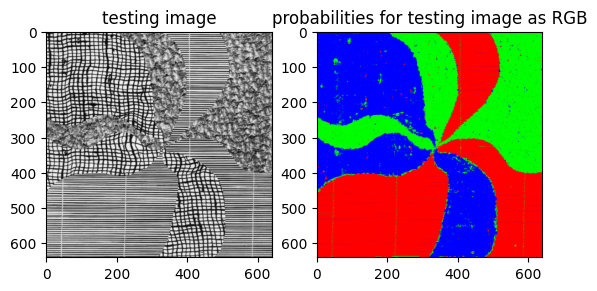

In [23]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(testing_image, cmap=plt.cm.gray)
ax[0].set_title('testing image')
ax[1].imshow(P_rgb)
ax[1].set_title('probabilities for testing image as RGB')
plt.show()

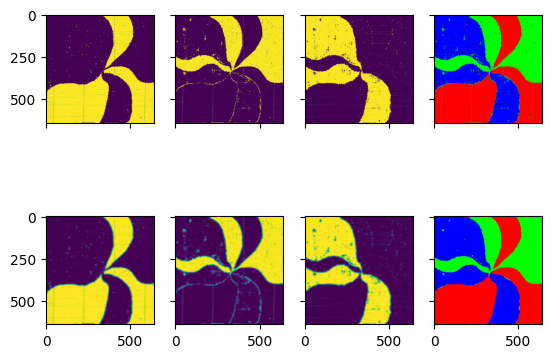

In [24]:
#%% SMOOTH PROBABILITY MAP

sigma = 3 # Gaussian smoothing parameter

seg_im_max = np.argmax(P_rgb,axis = 2)
c = np.eye(P_rgb.shape[2])
P_rgb_max = c[seg_im_max]

probability_smooth = np.zeros(probability_image.shape)
for i in range(0,probability_image.shape[2]):
    probability_smooth[:,:,i] = scipy.ndimage.gaussian_filter(probability_image[:,:,i],sigma,order=0)
seg_im_smooth = np.argmax(probability_smooth,axis=2)

probability_smooth_max = c[seg_im_smooth]

P_rgb_smooth = np.zeros(probability_smooth_max.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb_smooth[:,:,:k] = probability_smooth[:,:,:k]
P_rgb_smooth_max = np.zeros(probability_smooth_max.shape[0:2]+(3,))
P_rgb_smooth_max[:,:,:k] = probability_smooth_max[:,:,:k]

# Display result
fig,ax = plt.subplots(2,4,sharex=True,sharey=True)
ax[0][0].imshow(P_rgb[:,:,0])
ax[0][1].imshow(P_rgb[:,:,1])
ax[0][2].imshow(P_rgb[:,:,2])
ax[0][3].imshow(P_rgb_max)
ax[1][0].imshow(P_rgb_smooth[:,:,0])
ax[1][1].imshow(P_rgb_smooth[:,:,1])
ax[1][2].imshow(P_rgb_smooth[:,:,2])
ax[1][3].imshow(P_rgb_smooth_max)
plt.show()